In [1]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.1
    Uninstalling autograd-1.6.1:
      Successfully uninstalled autograd-1.6.1


In [2]:
%pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136820 sha256=4f2d361c0d83fb18e4fb3da2d437ee1cd2e43a0ab9fb32718f973ce44dbbb66a
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [4]:
%pip install jax

In [3]:
import pennylane as qml
import pennylane.numpy as np

In [5]:
import pennylane as qml
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [8]:
n_wires = 12
# Describe noise
noise_gate = qml.DepolarizingChannel
p = 0.005

In [9]:
# Load devices
dev_ideal = qml.device("default.mixed", wires=n_wires)
dev_noisy = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)

In [10]:
# 3x3 grid with nearest neighbors
connections = [(0, 1), (1, 2),
               (3, 4), (4, 5),
               (6, 7), (7, 8),
               (0, 3), (3, 6),
               (1, 4), (4, 7),
               (2, 5), (5, 8)]

In [11]:
def time_evolution(theta_h, n_layers = 10, obs = qml.PauliZ(4)):
    for _ in range(n_layers):
        for i, j in connections:
            qml.IsingZZ(-jnp.pi/2, wires=(i, j))
        for i in range(n_wires):
            qml.RX(theta_h, wires=i)
    return qml.expval(obs)

In [12]:
qnode_ideal = qml.QNode(time_evolution, dev_ideal, interface="jax")
qnode_noisy = qml.QNode(time_evolution, dev_noisy, interface="jax")


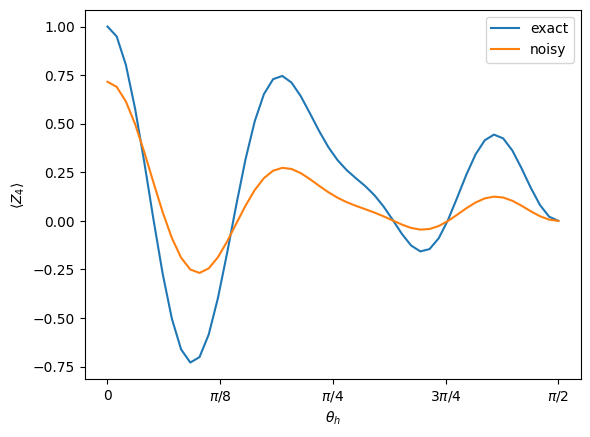

In [13]:
thetas = jnp.linspace(0, jnp.pi/2, 50)

res_ideal = jax.vmap(qnode_ideal)(thetas)
res_noisy = jax.vmap(qnode_noisy)(thetas)

plt.plot(thetas, res_ideal, label="exact")
plt.plot(thetas, res_noisy, label="noisy")
plt.xticks([0, jnp.pi/8, jnp.pi/4, 3*jnp.pi/8, jnp.pi/2], ["0", "$\\pi$/8", "$\\pi/4$", "$3\\pi/4$", "$\\pi/2$"])
plt.xlabel("$\\theta_h$")
plt.ylabel("$\\langle Z_4 \\rangle$")
plt.legend()
plt.show()

In [14]:
dev_noisy1 = qml.transforms.insert(noise_gate, p*1.2, position="all")(dev_ideal)
dev_noisy2 = qml.transforms.insert(noise_gate, p*1.6, position="all")(dev_ideal)

qnode_noisy1 = qml.QNode(time_evolution, dev_noisy1, interface="jax")
qnode_noisy2 = qml.QNode(time_evolution, dev_noisy2, interface="jax")

res_noisy1 = jax.vmap(qnode_noisy1)(thetas)
res_noisy2 = jax.vmap(qnode_noisy2)(thetas)

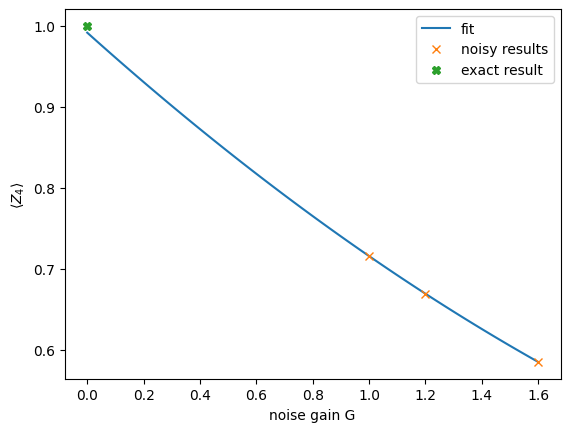

In [15]:
Gs = jnp.array([1., 1.2, 1.6])
y = jnp.array([res_noisy[0], res_noisy1[0], res_noisy2[0]])
coeff = jnp.polyfit(Gs, y, 2)
x = jnp.linspace(0, 1.6, 100)

plt.plot(x, jnp.polyval(coeff, x), label="fit")
plt.plot(Gs, y, "x", label="noisy results")
plt.plot([0], res_ideal[0], "X", label="exact result")
plt.xlabel("noise gain G")
plt.ylabel("$\\langle Z_4 \\rangle$")
plt.legend()
plt.show()